In [71]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io
from scipy import stats
import random
from tqdm import tqdm

# plt use ggplot stylesheet
plt.style.use('ggplot')

In [34]:
with open('temp/image-scoring-cogsci-data.json', 'r') as f:
    data = json.load(f)
    data = [entry for entry in data if entry.get('trial_type') == 'img-synth-response-anim']

print(f'Found {len(data)} sound trials')

Found 2344 sound trials


In [35]:
musical_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'musical']
referential_trials = [entry for entry in data if entry.get('session_info', {}).get('condition') == 'referential']
print(f'Found {len(musical_trials)} musical condition sounds')
print(f'Found {len(referential_trials)} referential condition sounds')

Found 1171 musical condition sounds
Found 1173 referential condition sounds


## interface interactions

In [69]:
heatmap_resolution = 6
canvas_size = 400  # pixels, set in jspsych experiment code

musical_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
referential_heatmap = np.zeros((heatmap_resolution, heatmap_resolution))
musical_xvals = []
musical_yvals = []
referential_xvals = []
referential_yvals = []

for entry in musical_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    musical_heatmap[y_bin, x_bin] += 1
                    musical_xvals.append(x)
                    musical_yvals.append(y)

for entry in referential_trials:
    for performance in entry.get('performances', []):
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_bin = min(int((x / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    y_bin = min(int((y / canvas_size) * heatmap_resolution), heatmap_resolution - 1)
                    referential_heatmap[y_bin, x_bin] += 1
                    referential_xvals.append(x)
                    referential_yvals.append(y)

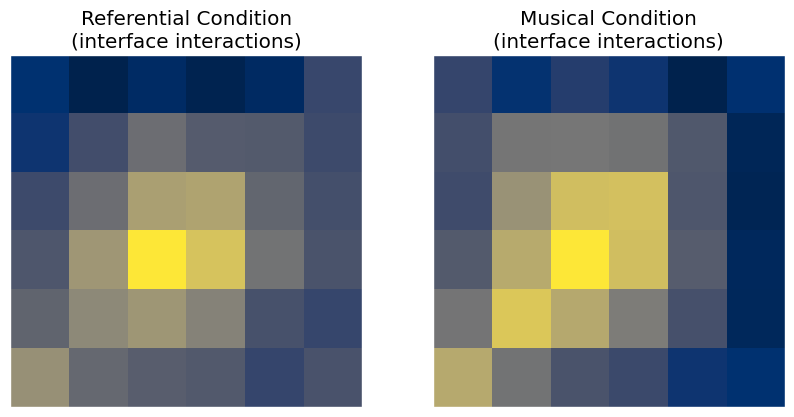

In [37]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(referential_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Referential Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(musical_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Musical Condition\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
corr = np.corrcoef(referential_heatmap.flatten(), musical_heatmap.flatten())[0, 1]
print(f'Correlation: r = {corr:.3f}')

Correlation: r = 0.893


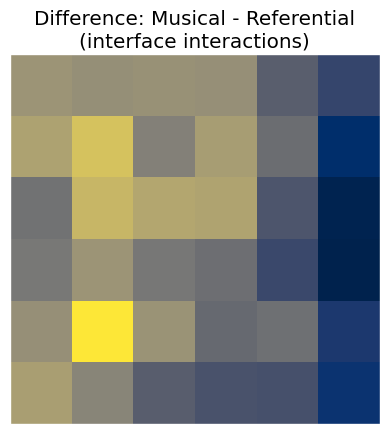

In [39]:
plt.imshow(musical_heatmap - referential_heatmap, cmap='cividis', interpolation='nearest')
plt.title('Difference: Musical - Referential\n(interface interactions)')
plt.xticks([])
plt.yticks([])
plt.show()

### pitch space and vibrato space distributions

In [40]:
print(f'number of musical interactions: {len(musical_xvals)}')
print(f'number of referential interactions: {len(referential_xvals)}')

number of musical interactions: 169322
number of referential interactions: 188287


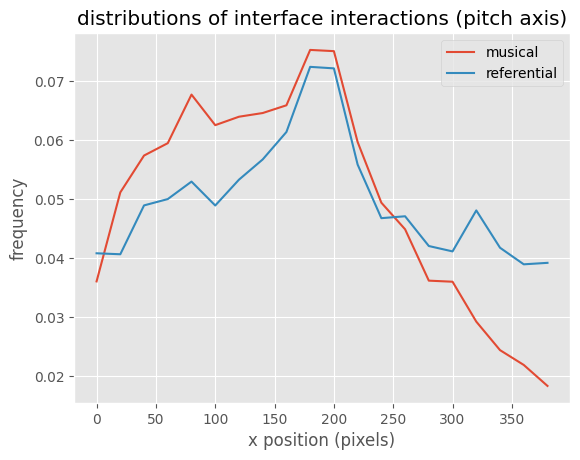

In [41]:
musical_pitch_hist = np.histogram(musical_xvals, bins=20, range=(0, canvas_size))
plt.plot(musical_pitch_hist[1][:-1], musical_pitch_hist[0]/len(musical_xvals), label='musical')
referential_pitch_hist = np.histogram(referential_xvals, bins=20, range=(0, canvas_size))
plt.plot(referential_pitch_hist[1][:-1], referential_pitch_hist[0]/len(referential_xvals), label='referential')
plt.xlabel('x position (pixels)')
plt.ylabel('frequency')
plt.title('distributions of interface interactions (pitch axis)')
plt.legend()
plt.show()

In [76]:
# compute 1D Earth Mover's Distance (Wasserstein) between x-position distributions
emd_x = stats.wasserstein_distance(musical_xvals, referential_xvals)
print(f'earth mover distance (pitch axis, pixels): {emd:.3f}')

earth mover distance (pitch axis, pixels): 3.389


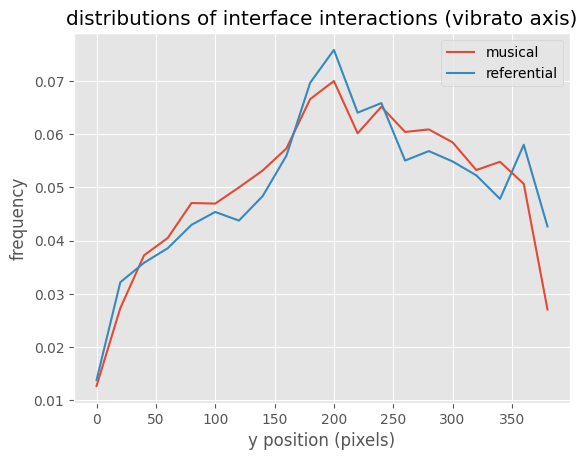

In [43]:
musical_vibrato_hist = np.histogram(musical_yvals, bins=20, range=(0, canvas_size))
plt.plot(musical_vibrato_hist[1][:-1], musical_vibrato_hist[0]/len(musical_yvals), label='musical')
referential_vibrato_hist = np.histogram(referential_yvals, bins=20, range=(0, canvas_size))
plt.plot(referential_vibrato_hist[1][:-1], referential_vibrato_hist[0]/len(referential_yvals), label='referential')
plt.xlabel('y position (pixels)')
plt.ylabel('frequency')
plt.title('distributions of interface interactions (vibrato axis)')
plt.legend()
plt.show()

In [74]:
# compute 1D Earth Mover's Distance (Wasserstein) between y-position distributions
emd_y = stats.wasserstein_distance(musical_yvals, referential_yvals)
print(f'earth mover distance (vibrato axis, pixels): {emd:.3f}')

earth mover distance (vibrato axis, pixels): 3.389


### shuffle participant labels for null distribution

In [93]:
n_shuffles = 200

In [94]:
x_EMDs = []
y_EMDs = []

for _ in tqdm(range(n_shuffles)):
    crossgroup_shuffled_participants = [[],[]]
    for trial in data:
        random_group = np.random.choice([0, 1])
        crossgroup_shuffled_participants[random_group].append(trial)

    shuffled_xvals_0 = []
    shuffled_xvals_1 = []
    shuffled_yvals_0 = []
    shuffled_yvals_1 = []
    
    for group in crossgroup_shuffled_participants:
        for entry in group:
            for performance in entry.get('performances', []):
                for event in performance.get('interactions', []):
                    if event.get('type') == 'mousemove':
                        x = event.get('x')
                        y = event.get('y')
                        if x is not None:
                            if group == crossgroup_shuffled_participants[0]:
                                shuffled_xvals_0.append(x)
                                shuffled_yvals_0.append(y)
                            else:
                                shuffled_xvals_1.append(x)
                                shuffled_yvals_1.append(y)
    
    x_EMD = stats.wasserstein_distance(shuffled_xvals_0, shuffled_xvals_1)
    x_EMDs.append(x_EMD)
    y_EMD = stats.wasserstein_distance(shuffled_yvals_0, shuffled_yvals_1)
    y_EMDs.append(y_EMD)

100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


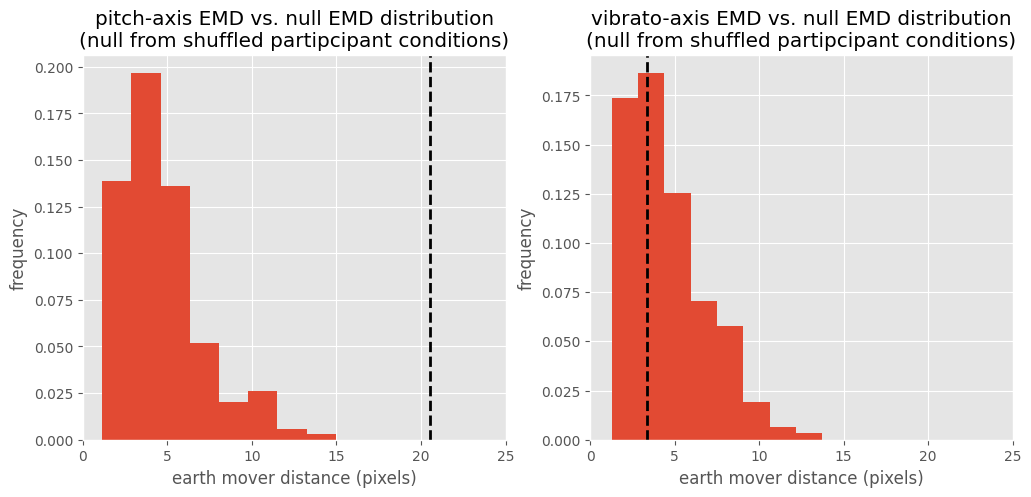

In [98]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(x_EMDs, bins=8, density=True)
plt.axvline(emd_x, color='k', linestyle='dashed', linewidth=2)
plt.title('pitch-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.xlim([0, 25])
plt.subplot(1,2,2)
plt.hist(y_EMDs, bins=8, density=True)
plt.axvline(emd_y, color='k', linestyle='dashed', linewidth=2)
plt.title('vibrato-axis EMD vs. null EMD distribution\n(null from shuffled partipcipant conditions)')
plt.xlabel('earth mover distance (pixels)')
plt.ylabel('frequency')
plt.xlim([0, 25])
plt.show()

### let's look at some other statistics per-sound

In [132]:
def calculate_curvature(x_coords, y_coords):
    """Calculate arc-length weighted average curvature from position data"""
    if len(x_coords) < 3:
        return 0.0
    
    curvatures = []
    arc_lengths = []
    
    for i in range(1, len(x_coords) - 1):
        # Get three consecutive points
        x1, y1 = x_coords[i-1], y_coords[i-1]
        x2, y2 = x_coords[i], y_coords[i]
        x3, y3 = x_coords[i+1], y_coords[i+1]
        
        # Calculate area of triangle formed by three points
        area = abs((x2 - x1) * (y3 - y1) - (x3 - x1) * (y2 - y1)) / 2.0
        
        # Calculate side lengths
        a = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        b = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        c = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        # Calculate arc length between adjacent points
        arc_length = (a + c) / 2.0
        
        # Calculate curvature using Menger curvature
        if a * b * c > 0 and arc_length > 0:
            curvature = 4 * area / (a * b * c)
            curvatures.append(curvature)
            arc_lengths.append(arc_length)
    
    # Calculate weighted average
    if sum(arc_lengths) > 0:
        avg_curvature = np.average(curvatures, weights=arc_lengths)
        return avg_curvature
    return 0.0

musical_performance_stats = []
referential_performance_stats = []

for entry in musical_trials:
    for performance in entry.get('performances', []):
        x_positions = []
        y_positions = []
        
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_positions.append(x)
                    y_positions.append(y)
        
        if len(x_positions) > 0:
            # Calculate standard deviation of positions
            all_positions = np.array(list(zip(x_positions, y_positions)))
            std_pos = np.std(all_positions)
            
            # Calculate average curvature
            avg_curvature = calculate_curvature(x_positions, y_positions)

            avg_velo_x = x_positions[-1] - x_positions[0]
            avg_velo_y = y_positions[-1] - y_positions[0]
            
            musical_performance_stats.append({
                'std_pos': std_pos,
                'avg_curvature': avg_curvature,
                'avg_velo_x': avg_velo_x,
                'avg_velo_y': avg_velo_y
            })

for entry in referential_trials:
    for performance in entry.get('performances', []):
        x_positions = []
        y_positions = []
        
        for event in performance.get('interactions', []):
            if event.get('type') == 'mousemove':
                x = event.get('x')
                y = event.get('y')
                if x is not None and y is not None:
                    x_positions.append(x)
                    y_positions.append(y)
        
        if len(x_positions) > 0:
            # Calculate standard deviation of positions
            all_positions = np.array(list(zip(x_positions, y_positions)))
            std_pos = np.std(all_positions)
            
            # Calculate average curvature
            avg_curvature = calculate_curvature(x_positions, y_positions)

            avg_velo_x = x_positions[-1] - x_positions[0]
            avg_velo_y = y_positions[-1] - y_positions[0]
            
            referential_performance_stats.append({
                'std_pos': std_pos,
                'avg_curvature': avg_curvature,
                'avg_velo_x': avg_velo_x,
                'avg_velo_y': avg_velo_y
            })

print(f'Musical performances: {len(musical_performance_stats)}')
print(f'Referential performances: {len(referential_performance_stats)}')

Musical performances: 1534
Referential performances: 1659


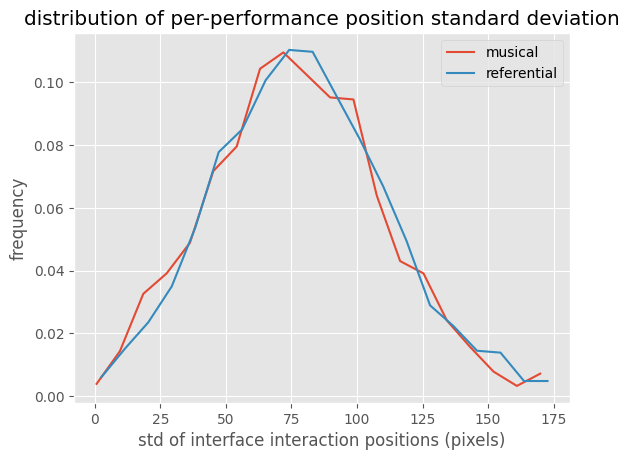

In [115]:
musical_std = np.histogram([performance.get('std_pos') for performance in musical_performance_stats], bins=20)
referential_std = np.histogram([performance.get('std_pos') for performance in referential_performance_stats], bins=20)

plt.plot(musical_std[1][:-1], musical_std[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_std[1][:-1], referential_std[0]/len(referential_performance_stats), label='referential')
plt.xlabel('std of interface interaction positions (pixels)')
plt.ylabel('frequency')
plt.title('distribution of per-performance position standard deviation')
plt.legend()
plt.show()

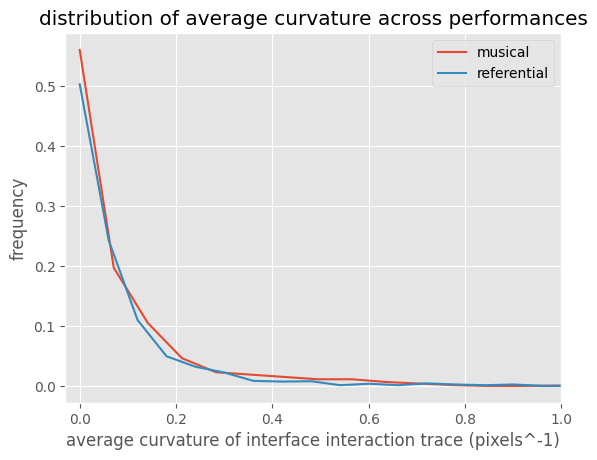

In [130]:
musical_curvature = np.histogram([performance.get('avg_curvature') for performance in musical_performance_stats], bins=20)
referential_curvature = np.histogram([performance.get('avg_curvature') for performance in referential_performance_stats], bins=20)
plt.plot(musical_curvature[1][:-1], musical_curvature[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_curvature[1][:-1], referential_curvature[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average curvature of interface interaction trace (pixels^-1)')
plt.ylabel('frequency')
plt.title('distribution of average curvature across performances')
plt.xlim([-0.03, 1])
plt.legend()
plt.show()

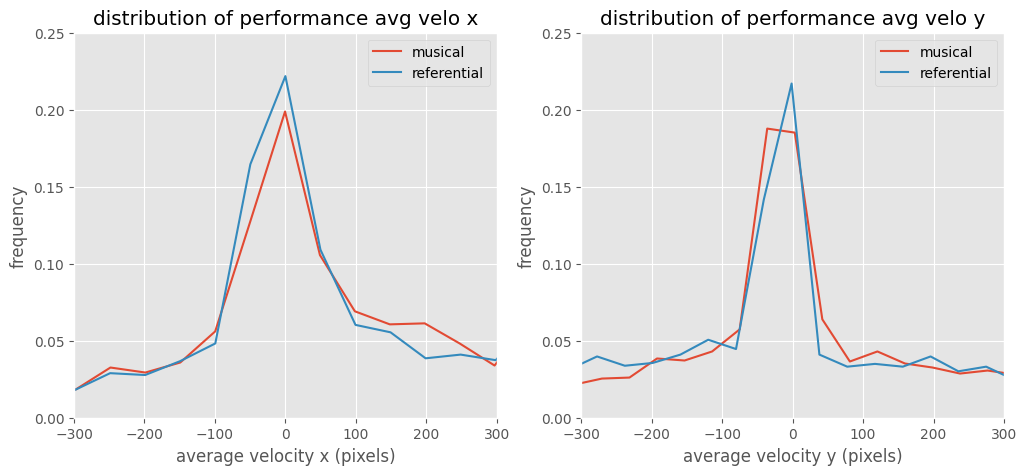

In [142]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
musical_velo_x = np.histogram([performance.get('avg_velo_x') for performance in musical_performance_stats], bins=16)
referential_velo_x = np.histogram([performance.get('avg_velo_x') for performance in referential_performance_stats], bins=16)
plt.plot(musical_velo_x[1][:-1], musical_velo_x[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_velo_x[1][:-1], referential_velo_x[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average velocity x (pixels)')
plt.ylabel('frequency')
plt.title('distribution of performance avg velo x')
plt.xlim([-300, 300])
plt.ylim([0, 0.25])
plt.legend()

plt.subplot(1, 2, 2)
musical_velo_y = np.histogram([performance.get('avg_velo_y') for performance in musical_performance_stats], bins=20)
referential_velo_y = np.histogram([performance.get('avg_velo_y') for performance in referential_performance_stats], bins=20)
plt.plot(musical_velo_y[1][:-1], musical_velo_y[0]/len(musical_performance_stats), label='musical')
plt.plot(referential_velo_y[1][:-1], referential_velo_y[0]/len(referential_performance_stats), label='referential')
plt.xlabel('average velocity y (pixels)')
plt.ylabel('frequency')
plt.title('distribution of performance avg velo y')
plt.xlim([-300, 300])
plt.ylim([0, 0.25])
plt.legend()

plt.show()

In [152]:
# Calculate means for referential performance stats
referential_means = {
    'std_pos': np.mean([p['std_pos'] for p in referential_performance_stats]),
    'avg_curvature': np.mean([p['avg_curvature'] for p in referential_performance_stats]),
    'avg_velo_x': np.mean([p['avg_velo_x'] for p in referential_performance_stats]),
    'avg_velo_y': np.mean([p['avg_velo_y'] for p in referential_performance_stats])
}

# Calculate means for musical performance stats
musical_means = {
    'std_pos': np.mean([p['std_pos'] for p in musical_performance_stats]),
    'avg_curvature': np.mean([p['avg_curvature'] for p in musical_performance_stats]),
    'avg_velo_x': np.mean([p['avg_velo_x'] for p in musical_performance_stats]),
    'avg_velo_y': np.mean([p['avg_velo_y'] for p in musical_performance_stats])
}

print('referential condition stats (averaged across all performances):')
for key, value in referential_means.items():
    print(f'  {key}: {value:.3f}')

print('\nmusical condition stats (averaged across all performances):')
for key, value in musical_means.items():
    print(f'  {key}: {value:.3f}')

referential condition stats (averaged across all performances):
  std_pos: 83.538
  avg_curvature: 0.101
  avg_velo_x: 38.128
  avg_velo_y: -6.600

musical condition stats (averaged across all performances):
  std_pos: 81.463
  avg_curvature: 0.109
  avg_velo_x: 41.450
  avg_velo_y: 5.722


In [148]:
n_shuffles = 200

avg_velo_x_nulls = []
avg_velo_y_nulls = []

for _ in tqdm(range(n_shuffles)):
    crossgroup_shuffled_participants = [[],[]]
    for trial in data:
        random_group = np.random.choice([0, 1])
        crossgroup_shuffled_participants[random_group].append(trial)

    avg_velo_x = [[],[]]
    avg_velo_y = [[],[]]
    
    for i, group in enumerate(crossgroup_shuffled_participants):
        for entry in group:
            for performance in entry.get('performances', []):
                    mousemoves = [event for event in performance.get('interactions', []) if event.get('type') == 'mousemove']
                    if len(mousemoves) > 1:
                        avg_velo_x[i].append(mousemoves[-1].get('x') - mousemoves[0].get('x'))
                        avg_velo_y[i].append(mousemoves[-1].get('y') - mousemoves[0].get('y'))

    avg_velo_x_nulls.append(np.mean(avg_velo_x[0]) - np.mean(avg_velo_x[1]))
    avg_velo_y_nulls.append(np.mean(avg_velo_y[0]) - np.mean(avg_velo_y[1]))

100%|██████████| 200/200 [00:05<00:00, 34.55it/s]


(array([0.00515805, 0.00515805, 0.02166382, 0.03610637, 0.02991671,
        0.05570697, 0.03094832, 0.01753738, 0.00206322, 0.00206322]),
 array([-22.35055226, -17.50376235, -12.65697243,  -7.81018252,
         -2.96339261,   1.88339731,   6.73018722,  11.57697714,
         16.42376705,  21.27055697,  26.11734688]),
 <BarContainer object of 10 artists>)

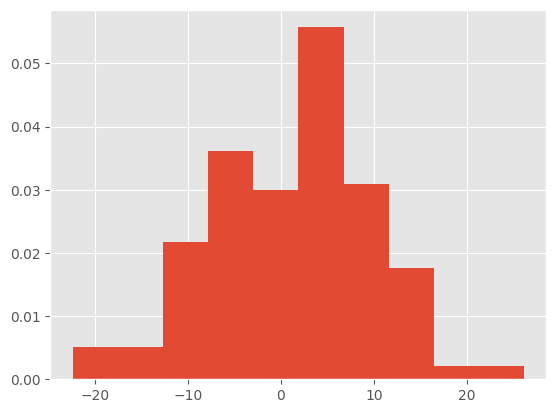

In [151]:
plt.hist(avg_velo_y_nulls, bins=10, density=True)